In [1]:
import os
import cv2
import sys
import random
import rasterio
import numpy as np
import tifffile as tiff
import matplotlib.image as mpimg
import rasterio 
from skimage.transform import rescale, resize

import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from rasterio.windows import Window

from keras import backend as K
from keras.layers import Conv2D
from keras import layers
from keras.models import Model

from matplotlib import pyplot as plt
from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN
from segmentation_models.utils import set_trainable

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping


os.environ['CUDA_VISIBLE_DEVICES'] = "1"

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Split on test, train, validation

In [3]:
train_img_list = []
test_img_list = []
val_img_list = []

train_list_split = ['0_0', '0_1', '0_2',
               '1_0', '1_2',
               '2_0', '2_1', '2_3', '2_4', '2_5',
               '3_1', '3_2', '3_3',
               '4_1', '4_3', '4_4', '4_5',
               '5_1', '5_2', '5_3', '5_4',
               '6_0', '6_1', '6_2', '6_4',
               '7_0', '7_1', '7_2', '7_3', '7_4']
val_list_split = ['1_1', '2_2', '4_2', '6_3']

# krasnoborsk
for folder in os.listdir('/home/user/data/krasnoborsk/world_view/'):
    if 'tif' in folder or 'xml' in folder or folder == 'lines':
        continue
    for file_name in os.listdir('/home/user/data/krasnoborsk/world_view/{}'.format(folder)):
        tmp_ind = file_name.split('_')[0]+'_'+file_name.split('_')[1]
        if tmp_ind in train_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in train_img_list:
            train_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]
        elif tmp_ind in val_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in val_img_list \
            and folder == '0':
            val_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]

# Novoshinsk
dse_pathechs = ['0_0', '0_1', '0_2',
               '1_0', '1_1', '1_2', '1_3',
               '2_0', '2_1', '2_2', '2_3', '2_4', 
               '3_0', '3_1', '3_2', '3_3', '3_4',
               '4_0', '4_1', '4_3', '4_4',
               '5_3', '5_4',
               '6_2', '6_3', '6_4',
               '7_2', '7_3', '7_4',
               '8_2', '8_3', '8_4']

for file_ind in [0, 1, 7, 9]: # 2 winter
    for patch_ind in dse_pathechs:
        i, j = patch_ind.split('_')
        if patch_ind +'_channel_0.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)) \
            or patch_ind +'_class_606.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)):
            continue
        if patch_ind in ['1_1', '2_2', '4_4']:
            test_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]
        else:
            train_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]


## New model

In [10]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')
from height_model_scripts.height_model_scripts import Generator

batch_size=20 
num_channels=4

generator = Generator(train_img_list, val_img_list, batch_size, num_channels)

generator.augm = True              # just geometric rotation is applied
generator.sharpen_flag = False     # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided
generator.clip_value = 40.         # the greatest height value 
generator.lidar_coef = 0           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 2    # target resolution both for height and imagery
generator.classifier_mode['regression'] = True

In [5]:
generator.write_gdalinfo_file()

In [6]:
generator.data_gdal

{'/home/user/data/krasnoborsk/world_view/4/height_1_0.tif': {'dx': 1.8943136583e-05,
  'dy': -8.869628916e-06,
  'x0': 45.67984678736104,
  'y0': 61.466215670458425,
  'size_x': 1918,
  'size_y': 2498},
 '/home/user/data/krasnoborsk/world_view/4/1_0_pan.tif': {'dx': 4.266978081e-06,
  'dy': -4.266978081e-06,
  'x0': 45.679864864207694,
  'y0': 61.46621609715774,
  'size_x': 8511,
  'size_y': 5192},
 '/home/user/data/krasnoborsk/world_view/4/1_0_class_606.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.68227469685591,
  'y0': 61.46621788701401,
  'size_x': 1984,
  'size_y': 1297},
 '/home/user/data/krasnoborsk/world_view/4/1_0_channel_0.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.6798655879806,
  'y0': 61.46621788701401,
  'size_x': 2125,
  'size_y': 1297},
 '/home/user/data/krasnoborsk/world_view/4/1_0_channel_1.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.6798655879806,
  'y0': 61.46621788701401,
  'size_x': 2125,
 

Text(0.5,1,'lidar')

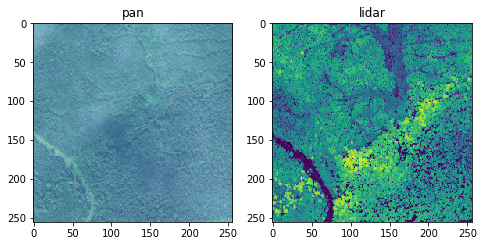

In [11]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('pan')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

Text(0.5,1,'lidar')

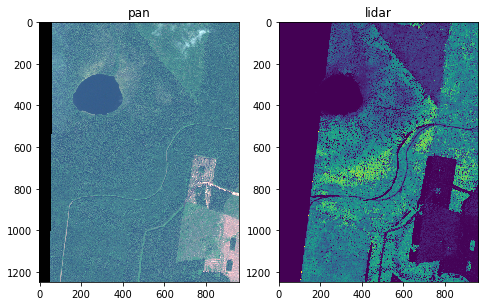

In [12]:
# check output
generator.augm = False
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[2])
generator.full_img = False
generator.augm = True   

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])# * (mask_pan>130))
a.set_title('pan')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

In [17]:
sys.path.insert(1, '../')
from height_model_scripts.loss_functions import rmse

model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), #-1
                  encoder_weights=None, activation='sigmoid')
loss =  rmse
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

/opt/conda/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

model_name = 'height_model_2m'
save_dir = '/home/user/data/example/data/Forestry_inventory/Height_model_paper/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [20]:
history=model.fit_generator(generator.train_gen(),epochs=25, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/25
200/200 [==============================] - 167s 833ms/step - loss: 0.1605 - rmse: 0.1605 - val_loss: 0.1708 - val_rmse: 0.1708

Epoch 00001: val_loss improved from inf to 0.17077, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/height_model_2m.h5

Epoch 00001: val_loss improved from inf to 0.17077, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/height_model_2m.hdf5
Epoch 2/25
200/200 [==============================] - 134s 668ms/step - loss: 0.1507 - rmse: 0.1507 - val_loss: 0.1551 - val_rmse: 0.1551

Epoch 00002: val_loss improved from 0.17077 to 0.15514, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/height_model_2m.h5

Epoch 00002: val_loss improved from 0.17077 to 0.15514, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/height_model_2m.hdf5
Epoch 3/25
200/200 [==============================] - 135s 674ms/step - loss: 0.1463 - rmse:

In [21]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [29]:
generator.augm  = False
prediction, full_mask = generator.pred_img(model)

In [23]:
pred_1=prediction[0]
maskarr_1=full_mask[0]
print('rmse', round(np.sqrt(np.sum(np.square(pred_1*generator.clip_value - maskarr_1*generator.clip_value*np.where(pred_1==0, 0, 1)))/np.sum(np.where(pred_1==0, 0, 1))), 3))
print('mae', round(np.sum(np.abs(pred_1*generator.clip_value - maskarr_1*generator.clip_value*np.where(pred_1==0, 0, 1)))/np.sum(np.where(pred_1==0, 0, 1)), 3))

rmse 5.352
mae 3.643


In [35]:
lidar_coef = 2.5
mask_0 = full_mask
mask_0 = np.expand_dims(cv2.resize(mask_0[0], (int(mask_0.shape[0]/lidar_coef), int(mask_0.shape[1]/lidar_coef)), 
                                   interpolation=cv2.INTER_AREA), 0)
mask_0 = np.expand_dims(cv2.resize(mask_0[0], (mask_0.shape[0], mask_0.shape[1]), interpolation=cv2.INTER_NEAREST), 0)

pred_1=prediction[0]
print('rmse', round(np.sqrt(np.sum(np.square(pred_1*generator.clip_value - maskarr_1*generator.clip_value*np.where(pred_1==0, 0, 1)))/np.sum(np.where(pred_1==0, 0, 1))), 3))
print('mae', round(np.sum(np.abs(pred_1*generator.clip_value - maskarr_1*generator.clip_value*np.where(pred_1==0, 0, 1)))/np.sum(np.where(pred_1==0, 0, 1)), 3))

rmse 4.591
mae 2.921


In [46]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

***
***

## Evaluation

In [42]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

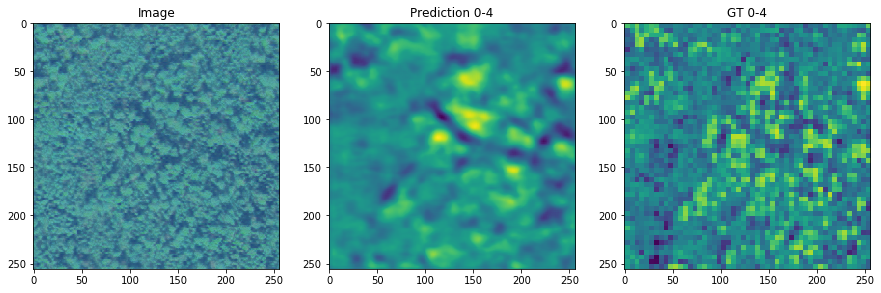

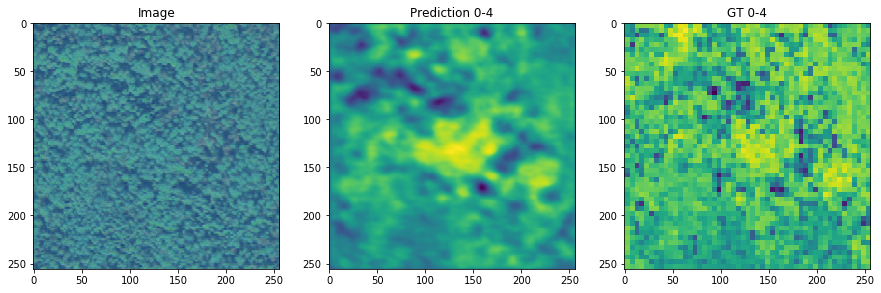

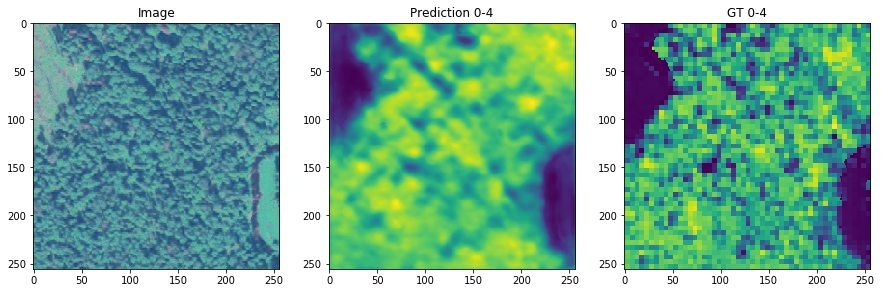

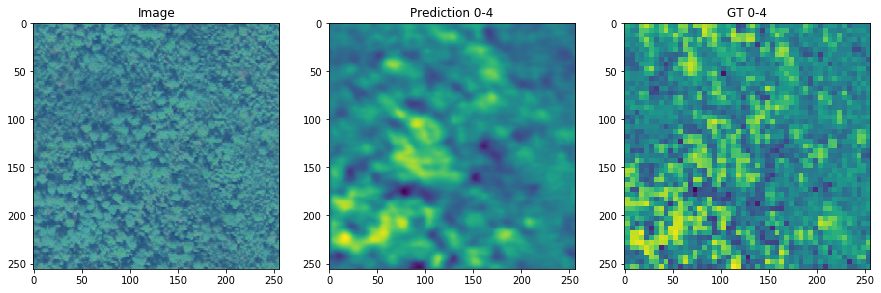

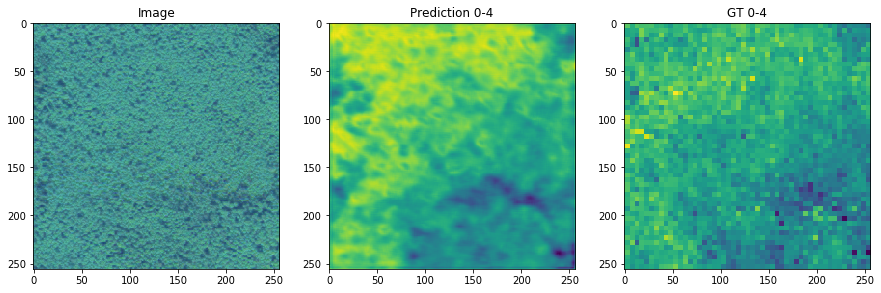

In [ ]:
for num in range(1, 15):
    fig = plt.figure(figsize=(15, 15))
    
    a = fig.add_subplot(1, 3, 1)
    a.set_title('Image')
    imgplot = plt.imshow(img[num,:,:,:3])
    
    cl=0
    a = fig.add_subplot(1, 3, 2)
    a.set_title('Prediction 0-4')
    imgplot = plt.imshow(pred[num, :, :,0]) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 3, 3)
    a.set_title('GT 0-4')
    imgplot = plt.imshow(mask[num, :, :,0])

# This part is from another notebook

## Save predictions

In [105]:
predicted_4cl, forestarr = generate_nir_new(model)

In [106]:
def save_pred(nir_img, dse_ind, cl_id='0'):    
   
    a = np.reshape(nir_img, (nir_img.shape[0], nir_img.shape[1]))
    #ret = str(subprocess.check_output("gdalinfo {}_channel_0.tif".format(dse_ind), shell=True))
    #imgpath[:-3] + 'height_' + imgpath.split('/')[-1]
    ret = str(subprocess.check_output("gdalinfo {}height_{}.tif".format(dse_ind[:-3], dse_ind.split('/')[-1]), shell=True))
    
    n = ret.find('Pixel Size')+len('Pixel Size = (')
    dx = float(ret[n:n+ret[n:].find(',')])
    dy = float(ret[1+n+ret[n:].find(','):n+ret[n:].find(')')])

    n = ret.find('Origin = (') + len('Origin = (')
    x0 = float(ret[n:n+ret[n:].find(',')])
    y0 = float(ret[1+n+ret[n:].find(','):n+ret[n:].find(')')])

    n = ret.find('Size is ')+len('Size is ')
    size_x = int(ret[n:n+ret[n:].find(',')])
    size_y = int(ret[2+n+ret[n:].find(','):n+ret[n:].find('\\')])
    
    nx = int(size_x) 
    ny = int(size_y)

    x1 = x0 + size_x*dx
    y1 = y0 + (size_y) * dy

    xmin, ymin, xmax, ymax = x0, y1, x1, y0 

    xres = dx
    yres = -dy
    geotransform = (xmin, xres, 0, ymax, 0, -yres)

    #dst_ds = gdal.GetDriverByName('GTiff').Create('/home/user/data/krasnoborsk/pred/{}_{}.tif'.format(dse_ind[-3:], cl_id),  nx, ny, 1, gdal.GDT_Byte)
    dst_ds = gdal.GetDriverByName('GTiff').Create('/home/user/data/krasnoborsk/pred/regr_{}.tif'.format(dse_ind[-3:]),  nx, ny, 1, gdal.GDT_Byte)
   
    '''
    mean = np.mean(a)
    std = np.std(a)
    m = max(a.min(), mean - 3*std) # a.min() --> 0
    M = min(a.max(), mean + 3*std)
    a = ((a - m)*255.0/(M-m)).clip(1, 255).astype(np.uint8)
    '''
    a = (a*30).astype(np.uint8)
    dst_ds.SetGeoTransform(geotransform)    # specify coords
    srs = osr.SpatialReference()            # establish encoding
    srs.ImportFromEPSG(4326) #3857)                #  32639 WGS84 lat/long
    dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    dst_ds.GetRasterBand(1).WriteArray(a)   # write r-band to the raster
    dst_ds.FlushCache()                     # write to disk
    dst_ds = None
    

In [107]:
import subprocess
from osgeo import gdal
from osgeo import osr
from os import listdir
from pyproj import Proj, transform
      
for dse_ind in range(len(val_img_list)):
    save_pred(predicted_4cl[dse_ind],val_img_list[dse_ind])

In [46]:
from aeronet.dataset import polygonize, BandCollection, FeatureCollection, parse_directory

In [ ]:
DIR = '/home/user/data/krasnoborsk/pred'
for dse_ind in range(len(val_img_list)):
    for i, cl_id in enumerate(['cl0', 'cl1', 'cl2', 'cl3']):
        file_name = val_img_list[dse_ind][-3:] + '_' + cl_id
        mask = BandCollection(parse_directory(DIR, [file_name]))
        vector = polygonize(mask[0], properties={'height': 'cl2'})
        vector.save('/home/user/data/krasnoborsk/pred/{}_{}.geojson'.format(val_img_list[dse_ind][-3:], cl_id))



In [108]:
def metric2tif(model, num_cl = 4, div_koef=5):
    
    pred=[]
    maskarr=[]
    for id_elem in range(len(val_img_list)):
        imgpath = val_img_list[id_elem]
        with rasterio.open(imgpath[:-3] + 'height_' + imgpath.split('/')[-1] +'.tif') as src:
            size_y = src.width #x y
            size_x = src.height
        dim = (size_x, size_y)
        mask = np.zeros((size_x// div_koef, size_y// div_koef, num_cl)) 
        with rasterio.open(imgpath[:-3] + 'height_' + imgpath.split('/')[-1] +'.tif') as src:
            mask_0 = src.read(1).astype(np.float)
            mask_0 = cv2.resize(mask_0, (size_y // div_koef, size_x // div_koef), interpolation=cv2.INTER_AREA)
        
        #class_606 = np.zeros((img.shape[0], img.shape[1], 1)) 
        with rasterio.open(imgpath+ '_class_606.tif') as src:
            mask_606 = src.read(1)
            mask_606 = cv2.resize(mask_606, (size_y// div_koef, size_x// div_koef), interpolation=cv2.INTER_NEAREST)

        #---------------------------------------------------------------------------------------
        # clean data
        #---------------------------------------------------------------------------------------
        felling = np.where(mask_0 < 1., 1, 0) * mask_606
        cloud = np.where(mask_0 > 5., 1, 0) * np.where(mask_606>0, 0, 1)
        mask_0 *= np.where(felling==1, 0, 1) * np.where(cloud==1, 0, 1)
        
        #print(dim)
        #print(mask.shape, mask_0.shape)
        mask[:,:,0] = np.where(mask_0>0, 1, 0)*np.where(mask_0<=4, 1, 0)
        mask[:,:,1] = np.where(mask_0>4, 1, 0)*np.where(mask_0<=10, 1, 0)
        mask[:,:,2] = np.where(mask_0>10, 1, 0)*np.where(mask_0<=20, 1, 0)
        mask[:,:,3] = np.where(mask_0>20, 1, 0)
        
        
        #element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        #erosion = cv2.erode(mask[:,:,1], element, iterations = 1)
        #mask[:,:,1] = cv2.dilate(erosion, element, iterations = 1)
        
        #return mask
        pred_tmp = np.zeros((size_x// div_koef, size_y// div_koef, num_cl), dtype=int) 
        with rasterio.open('/home/user/data/krasnoborsk/pred/regr_{}.tif'.format(imgpath.split('/')[-1])) as src:
            mask_0 = src.read(1)
            mask_0 = cv2.resize(mask_0, (size_y // div_koef, size_x // div_koef), interpolation=cv2.INTER_AREA)
        pred_tmp[:,:,0] = np.where(mask_0>=0, 1, 0)*np.where(mask_0<=4, 1, 0) 
        pred_tmp[:,:,1] = np.where(mask_0>4, 1, 0)*np.where(mask_0<=10, 1, 0)
        pred_tmp[:,:,2] = np.where(mask_0>10, 1, 0)*np.where(mask_0<=18, 1, 0)
        pred_tmp[:,:,3] = np.where(mask_0>18, 1, 0)
        #for i in range(num_cl):
        #    with rasterio.open('/home/user/data/krasnoborsk/pred/{}_cl{}.tif'.format(imgpath.split('/')[-1], i)) as src:
        #        pred_tmp[:,:,i] = src.read(1)
        #        pred_tmp[:,:,i] = np.where(pred_tmp[:,:,i]>0, 1, 0)
        
        #tiff.imshow(mask[:,:,0])
        #tiff.imshow(pred_tmp[:,:,0])
        #return
        pred.append(pred_tmp)
        maskarr.append(mask)
        #return(pred, maskarr)
    maskarr = np.asarray(maskarr) 
    pred = np.asarray(pred) 
    
    precision = np.zeros((num_cl))
    recall = np.zeros((num_cl))
    f1_cl = np.zeros((num_cl))
  
    for cl in range(num_cl):
        recall[cl] = np.sum(maskarr[:,:,:,cl]*np.where(pred[:,:,:,cl]==1, 1, 0)) / np.sum(maskarr[:,:,:,cl])
        precision[cl] = np.sum(maskarr[:,:,:,cl]*np.where(pred[:,:,:,cl]==1, 1, 0)) / np.sum(np.sum(maskarr, axis=-1)*np.where(pred[:,:,:,cl]==1, 1, 0))

    f1_cl = 2*((precision*recall)/(precision+recall))

    classes = ['0', '1', '2','4' ]
    for i in range(num_cl):
        print(classes[i], ': precision ', round(precision[i], 5), ' recall ', round(recall[i], 5), ' f1 ', round(f1_cl[i], 5))
        print(' ')